# Problem Description Image

In [13]:
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import xml.etree.ElementTree as ET

In [6]:
def xml_tree_roi_from_vsi(vsi_file):

    xml_identifier_start = '<?xml '
    xml_identifier_stop = '</siXML>'

    with open(vsi_file, errors='ignore') as f:
        vsi_string = f.read()

    vsi_string = vsi_string.replace(u'\u0000', '')

    xml_start = vsi_string.find(xml_identifier_start)
    xml_stop = vsi_string.find(xml_identifier_stop)

    if xml_start == -1 or xml_stop == -1:
        print('{} does not contain ROI XML Element.'.format(vsi_file))
        return None

    xml_string = vsi_string[xml_start:xml_stop+len(xml_identifier_stop)]

    return ET.fromstring(xml_string)


def get_polygon_vectors(xml_tree):

    polygons = list()

    for polygon in xml_tree.findall(".//Property[@Key='measure:ShapePoints']"):

        coordinates = [float(c.text) for c in polygon.findall("./Component/CdVec2/double")]
        polygons.append(np.reshape(coordinates, (2, -1), order='F'))

    return polygons


def img_dim_from_metadata_xml(metadata_xml):

    requested_attributes = [
        'PhysicalSizeX',
        'PhysicalSizeY',
        'PhysicalSizeXUnit',
        'PhysicalSizeYUnit',
        'SizeX',
        'SizeY'
    ]

    ns = {'ome': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}

    tree = ET.parse(metadata_xml)
    elem = tree.find(".//ome:Image[@ID='Image:0']/ome:Pixels", ns)

    return_dict = dict()

    for a in requested_attributes:
        return_dict[a] = elem.get(a)

    return return_dict

In [10]:
vsi = '/media/jacob/phillip/ShortTermIntervention/HE/18.10/18.10 OT46_1.vsi'
img = '/media/jacob/phillip/ShortTermIntervention/HE/18.10/_18.10 OT46_1_/images/18_10_OT46_1.tif'
metadata = '/media/jacob/phillip/ShortTermIntervention/HE/18.10/_18.10 OT46_1_/18_10_OT46_1__metadata.xml'

In [11]:
xml_tree = xml_tree_roi_from_vsi(vsi)
polygons = get_polygon_vectors(xml_tree)
img_dim = img_dim_from_metadata_xml(metadata)
img = Image.open(img)

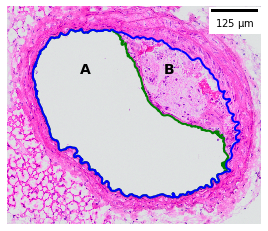

In [22]:
plt.figure()
plt.imshow(img)
plt.plot(polygons[0][0],polygons[0][1], linewidth=2, color='green')
plt.plot(polygons[1][0],polygons[1][1], linewidth=2, color='blue')
plt.xlim(4600, 8800)
plt.ylim(4400, 800)
plt.text(5800, 1900, 'A', fontweight='bold', size=14)
plt.text(7200, 1900, 'B', fontweight='bold', size=14)
plt.axis('off')
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
scalebar = ScaleBar(img_dim['PhysicalSizeX'], 'um')
plt.gca().add_artist(scalebar)
plt.savefig('problem_description.png', bbox_inches='tight', dpi=1200, pad_inches=0)
plt.show()